In [1]:
import ete3
import re
import os
import sys
import ast
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Extract the information of ages from the phylogenies

In [2]:
## Extract age information from the phylogenies
with open("Gene Tree Age Posteriors.datedist") as f:
    content = f.readlines()
content = [x.strip() for x in content] 

tree = ete3.Tree(content[0],format=1)

def Remove_Duplicate(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

leaf_list = []
for leaf in tree.get_leaves():
    leaf_list.append(leaf.name)
    
leaf_node_list = []
for node in tree.traverse():
    if node.is_leaf():
        leaf_node_list.append(node.name)
        
def node_age_on_each_tree(tree):
    leaf_node_list = []
    internal_age_list = []
    for node in tree.traverse():
        if node.is_leaf():
            leaf_node_list.append(node.name)
        else:
            internal_age_list.append(node.name)
    return internal_age_list 

All_Sample_Age_List = []
for i in range (0, len(content)):
    tree = ete3.Tree(content[i],format=1)
    One_Age_List = node_age_on_each_tree(tree)
    All_Sample_Age_List.append(One_Age_List)
df=pd.DataFrame(All_Sample_Age_List)

# Take the first 3829 trees from the solution space of tress; 
# The index in "[]" can be changed for different "burn-in" we want.
df_list_1  = df[0:3840] 
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]

# Change the ages in the list to negative numbers# Divide the number of nodes in each bin (corresponding to the )
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])


SAR202_clade = tree.get_common_ancestor(['SAR202clusterbacteriumIo17ChloroG3_PKB65232', 'SAR202clusterbacteriumIo17ChloroG9_PKB79601'])
children = SAR202_clade.get_descendants()

# Append the crown SAR202 to the children list
children.append(SAR202_clade) 

f = open('Age_Tree_SAR202-Clade_string', 'r')
lines = f.read()
SAR202_age_list_row_one = re.findall(r"'(\d+\.\d+|\d+)'", lines) 
SAR202_age_list_row_one = [float(i) for i in SAR202_age_list_row_one]

df_list_row_one = df.iloc[0]
df_list_row_one = df_list_row_one.values.tolist()
df_list_row_one = [float(i) for i in df_list_row_one]

Internal_node_SAR202_clade_list = []
for element in SAR202_age_list_row_one:
    if element in df_list_row_one:
        Internal_node_SAR202_clade_list.append(df_list_row_one.index(element))
        
# Take the first 3829 trees from the solution space of tress; 
# The index in "[]" can be changed for different "burn-in" we want.
df_list_1  = df[Internal_node_SAR202_clade_list]
df_list_1 = df_list_1.values.tolist()
merged_df_list_1 = sum(df_list_1, [])
cleaned_df_list_1 = [float(x) for x in merged_df_list_1]

# Change the ages in the list to negative numbers# Divide the number of nodes in each bin (corresponding to the )
negative_age_list_1 = sorted([-x for x in cleaned_df_list_1 ])

## Compute the BVMO diversification rates

In [3]:
# Compute the per-gene diversification rates of BVMOs; refer to Mtehods section in the main text for the corresponding theory
bin_size = 100
his_data_eight_calibration_1 = np.histogram(negative_age_list_1, bins=27, range = (-2700, 0))
age_interval_list = his_data_eight_calibration_1[1]
age_interval_list = age_interval_list.tolist()
middle_age_interval_list = [left_age + (bin_size/float(2)) for left_age in age_interval_list]
del middle_age_interval_list[-1]
node_number_each_interval = his_data_eight_calibration_1[0]
node_number_each_interval = node_number_each_interval.tolist()
node_number_each_interval_normalized_by_tree_number = [i / float(len(df_list_1)) for i in node_number_each_interval]
node_density_each_interval_normalized_by_tree_number = [i / float(bin_size) for i in node_number_each_interval_normalized_by_tree_number]
log_node_density_each_interval_normalized_by_tree_number = [np.log(i) for i in node_density_each_interval_normalized_by_tree_number]
log_node_density_array= np.array(log_node_density_each_interval_normalized_by_tree_number)
Diversification_Rates = log_node_density_array[1:27] - log_node_density_array[0:26]

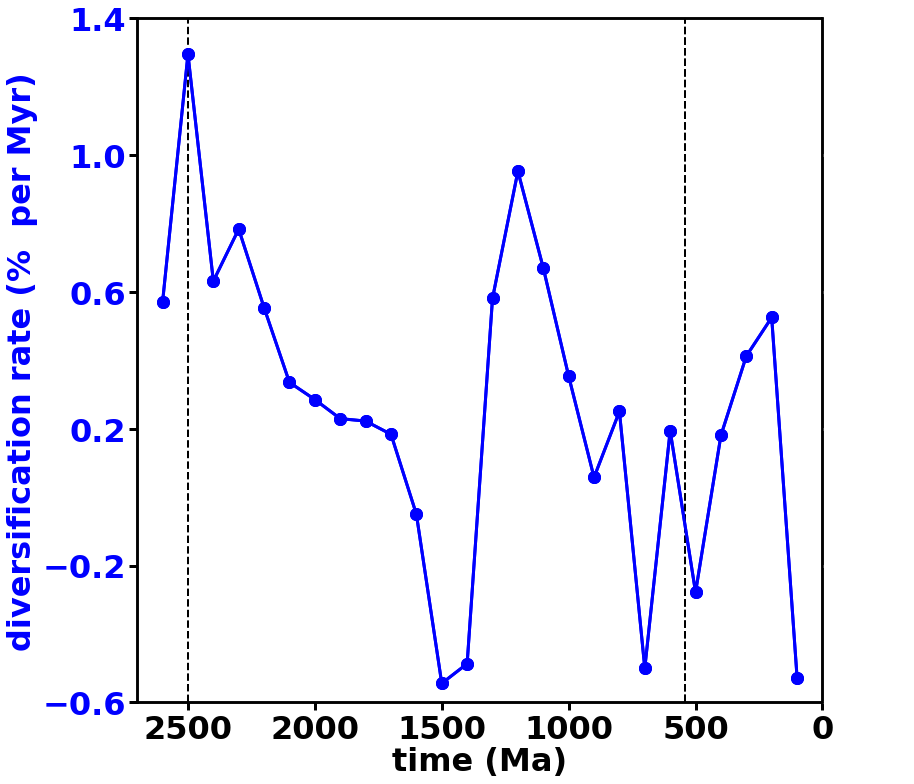

In [4]:
# Plot BVMo diversification rates along geologic time
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,13))
Diversification_Step_Age = np.linspace(2600., 100., num=26) # Time steps 
plt.plot(Diversification_Step_Age[0:26], Diversification_Rates[0:26], 'o-', markersize=12, color='blue', linewidth=3)
plt.axvline(x=2500, linewidth=2, color='black', linestyle='--')
plt.axvline(x=541, linewidth=2, color='black', linestyle='--')
plt.axvline(x=541, linewidth=2, color='black', linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=32, width=3, length=8)
plt.xlabel('time (Ma)',  size = '32', weight='bold')
ax1.xaxis.labelpad = 1
plt.ylabel('diversification rate (%  per Myr)',  size = '32', weight='bold',color='blue')
plt.xticks(np.arange(0, 2700, step=500), weight='bold')
plt.yticks(np.arange(-0.6, 1.5, step=0.4), weight='bold', color='blue')
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.xlim(0, 2700)
plt.ylim(-0.6, 1.4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(Diversification_Step_Age[0:26], Diversification_Rates[0:26], 'o-', markersize=12, color='blue', linewidth=3)
ax2.set_ylabel("", size = '32', weight='bold', color="white")
ax2.tick_params(axis='y', which='major', labelsize=32, width=3, color="white")
plt.xticks(np.arange(0, 2700, step=500), weight='bold')
plt.yticks(np.arange(-0.6, 1.5, step=0.4), color="white")
plt.xlim(0, 2700)
plt.ylim(-0.6, 1.4)

ax = fig.gca()
ax.figure.set_size_inches(12.8, 11)
plt.gca().invert_xaxis()
plt.setp(ax.spines.values(), linewidth=2.5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('diversification.jpg', dpi=500)
plt.show()

## Compare the BVMO diversification rates and the Phanerozoic atmospheric oxygen levels

In [5]:
# The oxygen levels (mass) in Phanerozoic reported by Berner (reference [39] in the main text)
# Three "38"'s have been added at the left side (i.e., before 570 Ma) of the time seires as an extrapolation
Phanerozoic_Oxygen_Levels = np.array([38, 38, 38, 38, 36, 34, 34, 34, 34, 34, 34, 34, 34, 32, 32, 32, 
                                             32, 30, 30, 30, 28, 26, 24, 38, 42, 45, 54, 62, 68, 76, 78, 80, 
                                             70, 60, 50, 40, 30, 26, 30, 30, 30, 26, 36, 38, 40, 42, 42, 42, 
                                             42, 44, 46, 48, 50, 50, 48, 46, 44, 42, 41, 40, 38])

# A function to compute moverage averages
def moving_average(array, window_length):
    cumulative_sum = np.cumsum(array, dtype=float)
    cumulative_sum[window_length:] = cumulative_sum[window_length:] - cumulative_sum[:-window_length]
    return cumulative_sum[window_length:] / window_length

# The Phanerozoic oxygen levels are smoothed over 200 Myr, which the resolution of the phylogenetics reconstruction.   
moving_average_oxygen = moving_average(Phanerozoic_Oxygen_Levels, 20)

# Sample every 100 Myr from the data in the array "moving_average_oxygen" for the plot
oxygen_levels_for_plot = moving_average_oxygen[[0, 10, 20, 30, 40]]

# Divide the data in the array "oxygen_levels_for_plot" by Earth's modern atmospheric level (mass), that is, 37.5 by Berner (reference [39] in the main text)
relative_oxygen_levels_for_plot = oxygen_levels_for_plot/37.5
relative_oxygen_levels_for_plot

array([0.89066667, 1.10266667, 1.27866667, 1.12533333, 1.12666667])

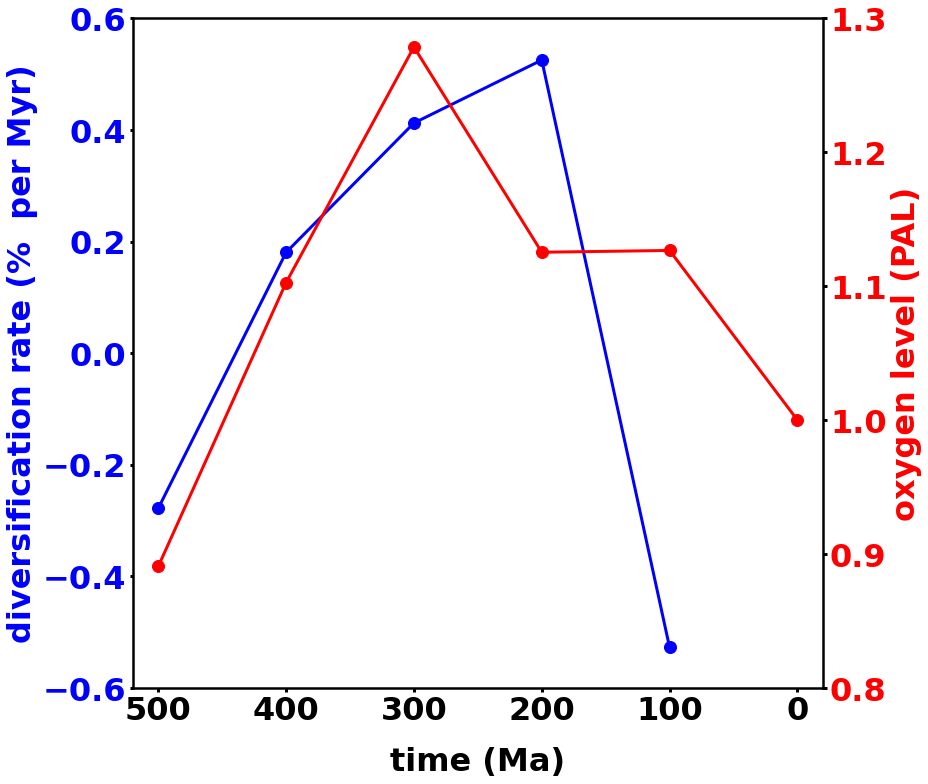

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,13))
ax = fig.gca()

plt.plot(Diversification_Step_Age[21:27], Diversification_Rates[21:27], 'o-', 
         markersize=12, color='blue', linewidth=3)
ax1.tick_params(axis='both', which='major', labelsize=32, width=3)
plt.xlabel('time (Ma)',  size = '32', weight='bold')
plt.ylabel('diversification rate (%  per Myr)',  size = '32', weight='bold', color="blue")
ax1.xaxis.labelpad = 20
plt.xticks(np.arange(-200, 600, step=100), weight='bold')
plt.yticks(np.arange(-0.6, 0.7, step=0.2), weight='bold', color="blue")
plt.setp(ax.spines.values(), linewidth=2.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(np.array([500, 400, 300, 200, 100, 0]), np.array([0.89066667, 1.10266667, 1.27866667, 1.12533333, 1.12666667, 1]), 
         'o-', markersize=12, color='red', linewidth=3)
ax2.set_ylabel("oxygen level (PAL)", size = '32', weight='bold', color="red")
ax2.tick_params(axis='y', which='major', labelsize=32, width=3)
plt.yticks(np.arange(0.8, 1.6, step=0.1), weight='bold', color="red")
plt.xticks(np.arange(0, 600, step=100), weight='bold')
plt.xlim(-20,520)
plt.ylim(0.8,1.3)

plt.gca().invert_xaxis()
ax2.figure.set_size_inches(13, 11)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Berner oxygen.jpg', dpi=500)
plt.show()